# Klasyfikacja "Czy jutro będzie padać?"

Target:

- czy będzie padać w ciągu następnego dnia?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier

from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    confusion_matrix
)
from sklearn.inspection import permutation_importance


plt.style.use('seaborn-v0_8-whitegrid')

DATA_DIR = Path('data')

df = pd.read_csv(DATA_DIR / 'combined_rain.csv', parse_dates=['time'], index_col='time')

#### Prosty preprocessing - agregacje do baselinów, i żeby móc sprawdzać przy xgb, czy dodawanie kolejnych cech ma sens

In [2]:
def prepare_data(df):
    # BASIC FEATURES FOR XGBOOST
    df = df.copy().sort_index()

    daily = (
        df
        .resample("D")
        .agg({
            "prcp": "sum",
            "temp": "mean",
            "pres": "mean",
            "rhum": "mean",
            "wspd": "mean"
        })
    )

    # TARGET: czy padało danego dnia
    daily["rain_today"] = (daily["prcp"] > 0).astype(int)
    daily["rain_tomorrow"] = daily["rain_today"].shift(-1)
    daily = daily.dropna()
    # cechy kalendarzowe
    daily["month"] = daily.index.month
    daily["day_of_year"] = daily.index.dayofyear

    # # kodowanie cykliczne
    daily["doy_sin"] = np.sin(2 * np.pi * daily["day_of_year"] / 365)
    daily["doy_cos"] = np.cos(2 * np.pi * daily["day_of_year"] / 365)

    daily = daily.dropna()
    return daily


#### Dodatkowe cechy

In [3]:
def prepare_data_2(df):
    # BETTER FEATURES FOR XGBOOST
    df = df.copy().sort_index()

    # TARGET DZIENNY
    daily_prcp = df["prcp"].resample("D").sum()
    rain_today = (daily_prcp > 0).astype(int)
    rain_tomorrow = rain_today.shift(-1)

    # SNAPSHOT GODZINOWY
    # Bierzemy dane z wieczora poprzedniego dnia
    SNAPSHOT_HOUR = 23
    df_snap = df[df.index.hour == SNAPSHOT_HOUR].copy()
    df_snap.index = df_snap.index.normalize()

    X = pd.DataFrame(index=df_snap.index)

    # STAN AKTUALNY
    X["temp"] = df_snap["temp"]
    X["pres"] = df_snap["pres"]
    X["rhum"] = df_snap["rhum"]
    X["wspd"] = df_snap["wspd"]

    # # PUNKT ROSY
    X["dew_point"] = X["temp"] - ((100 - X["rhum"]) / 5)

    # TRENDY

    # def lag(col, h):
    #     return df[col].shift(h).loc[X.index]
    # X["pres_drop_6h"]  = X["pres"] - lag("pres", 6)
    # # X["pres_drop_12h"] = X["pres"] - lag("pres", 12)

    X["rhum_rise_3h"]  = X["rhum"] - df["rhum"].shift(3).loc[X.index]
    # X["rhum_rise_6h"]  = X["rhum"] - lag("rhum", 6)
    # X["rhum_rise_12h"] = X["rhum"] - lag("rhum", 12)

    # X["temp_trend_12h"] = X["temp"] - lag("temp", 12)

    # # HISTORIA OPADÓW
    daily_prcp_hist = daily_prcp.loc[X.index]
    X["prcp_1d"] = daily_prcp_hist.shift(1)
    X["rain_yesterday_any"] = (X["prcp_1d"] > 0).astype(int)

    # # SEZONOWOŚĆ
    doy = X.index.dayofyear
    X["doy_sin"] = np.sin(2 * np.pi * doy / 365)
    X["doy_cos"] = np.cos(2 * np.pi * doy / 365)

    # # SĄSIEDZI
    NEIGHBORS = ["Legnica", "Opole", "Poznan", "Klodzko"]

    # for city in NEIGHBORS:
    #     tcol = f"temp_{city}"
    #     pcol = f"pres_{city}"

    #     if tcol in df_snap.columns:
    #         X[f"temp_diff_{city}"] = df_snap[tcol] - df_snap["temp"]

    #     if pcol in df_snap.columns:
    #         X[f"pres_diff_{city}"] = df_snap[pcol] - df_snap["pres"]

    # OPADY U SĄSIADÓW (OSTATNIE 6 i 12 h)
    for city in NEIGHBORS:
        prcp_col = f"prcp_{city}"
        if prcp_col in df.columns:
            # suma opadów u sąsiada w ostatnich 6 godzinach
            prcp_6h = df[prcp_col].rolling(6).sum().shift(1)
            X[f"neighbor_rain_6h_{city}"] = (prcp_6h.loc[X.index] > 0).astype(int)

            prcp_12h = df[prcp_col].rolling(12).sum().shift(1)
            X[f"neighbor_rain_12h_{city}"] = (prcp_12h.loc[X.index] > 0).astype(int)


    wdir = df['wdir'] # kierunek wiatru
    X['wdir_sin'] = np.sin(np.deg2rad(wdir))
    X['wdir_cos'] = np.cos(np.deg2rad(wdir))
    
    # POŁĄCZENIE Z TARGETEM
    data = X.join(rain_tomorrow.rename("rain_tomorrow"), how="inner")

    data = data.dropna()
    return data

In [4]:
daily = prepare_data(df)
TEST_DAYS = 365

train = daily.iloc[:-TEST_DAYS]
test  = daily.iloc[-TEST_DAYS:]

X_train = train.drop(columns=["rain_tomorrow"])
y_train = train["rain_tomorrow"]

X_test = test.drop(columns=["rain_tomorrow"])
y_test = test["rain_tomorrow"]

### Modele baseline:

1. będzie tak jak wczoraj
2. losowo, prawdopodobieństwo deszczu 50%
3. losowo, prawdopodobieństwo deszczu proporcjonalne do udziału dni z deszczem w zbiorze treningowym
4. losowo, prawdopodobieństwo deszczu proporcjonalne do udziału dni z deszczem w zbiorze treningowym w danym miesiącu

1. będzie tak jak wczoraj

In [5]:
# przesunięcie o 1 dzień
y_pred_yesterday = daily["rain_today"]

# tylko część testowa
y_pred_yesterday_test = y_pred_yesterday.loc[test.index]
print(classification_report(y_test, y_pred_yesterday_test, digits=3))


              precision    recall  f1-score   support

         0.0      0.692     0.692     0.692       195
         1.0      0.647     0.647     0.647       170

    accuracy                          0.671       365
   macro avg      0.670     0.670     0.670       365
weighted avg      0.671     0.671     0.671       365



2. losowo, prawdopodobieństwo deszczu 50%

In [6]:
rng = np.random.default_rng(seed=42)

y_pred_random_50 = rng.binomial(
    n=1,
    p=0.5,
    size=len(test)
)

y_pred_random_50 = pd.Series(
    y_pred_random_50,
    index=test.index
)

print(classification_report(y_test, y_pred_random_50, digits=3))


              precision    recall  f1-score   support

         0.0      0.522     0.492     0.507       195
         1.0      0.453     0.482     0.467       170

    accuracy                          0.488       365
   macro avg      0.487     0.487     0.487       365
weighted avg      0.490     0.488     0.488       365



3. losowo, prawdopodobieństwo deszczu proporcjonalne do udziału dni z deszczem w zbiorze treningowym

In [7]:
p_rain = y_train.mean()

y_pred_random_prior = rng.binomial(
    n=1,
    p=p_rain,
    size=len(test)
)

y_pred_random_prior = pd.Series(
    y_pred_random_prior,
    index=test.index
)
print(classification_report(y_test, y_pred_random_prior, digits=3))



              precision    recall  f1-score   support

         0.0      0.558     0.518     0.537       195
         1.0      0.489     0.529     0.508       170

    accuracy                          0.523       365
   macro avg      0.524     0.524     0.523       365
weighted avg      0.526     0.523     0.524       365



4. losowo, prawdopodobieństwo deszczu proporcjonalne do udziału dni z deszczem w zbiorze treningowym w danym miesiącu


In [8]:
# dodaj miesiąc
train = train.copy()
test = test.copy()

# p(rain | month) z train
monthly_rain_prob = (
    train
    .groupby("month")["rain_today"]
    .mean()
)
rng = np.random.default_rng(seed=42)

y_pred_random_monthly = []

for ts, row in test.iterrows():
    m = row["month"]

    # zabezpieczenie, gdyby jakiegoś miesiąca nie było w train
    p = monthly_rain_prob.get(m, y_train.mean())

    y_pred_random_monthly.append(
        rng.binomial(n=1, p=p)
    )

y_pred_random_monthly = pd.Series(
    y_pred_random_monthly,
    index=test.index
)
print(classification_report(y_test, y_pred_random_monthly, digits=3))

              precision    recall  f1-score   support

         0.0      0.578     0.549     0.563       195
         1.0      0.511     0.541     0.526       170

    accuracy                          0.545       365
   macro avg      0.545     0.545     0.544       365
weighted avg      0.547     0.545     0.546       365



In [9]:
def eval(model, X_test, y_test, t=0.5):
    # EVALUATION FOR XGB
    preds_prob = model.predict_proba(X_test)[:, 1] # Prawdopodobieństwo deszczu
    preds_bin = (preds_prob > t).astype(int)      # Klasyfikacja tak/nie

    print()
    print(f"Raport klasyfikacji, threshold={t}")
    print(classification_report(y_test, preds_bin, digits=3))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, preds_prob):.4f}")
    print("Confusion matrix:")
    print(confusion_matrix(y_test, preds_bin))

    # false positives vs false negatives for different thresholds
    thresholds = np.linspace(0.01, 0.99, 99)
    fps, fns = [], []
    for t in thresholds:
        y_pred = (preds_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fps.append(fp)
        fns.append(fn)
    plt.figure(figsize=(6,5))
    plt.plot(thresholds, fps, label="False Positives")
    plt.plot(thresholds, fns, label="False Negatives")
    plt.xlabel("Threshold")
    plt.ylabel("Count")
    plt.title("FP / FN vs threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Przykład prognozy prawdopodobieństwa
    plt.figure(figsize=(15, 5))
    subset_len = 24 * 14 # 2 tygodnie
    plt.plot(y_test.index[-subset_len:], y_test.values[-subset_len:], 'k|', label='Faktyczny deszcz', markersize=10)
    plt.fill_between(y_test.index[-subset_len:], 0, preds_prob[-subset_len:], color='blue', alpha=0.3, label='Prawdopodobieństwo deszczu')
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Próg 50%')
    plt.title("Prognoza prawdopodobieństwa wystąpienia opadów")
    plt.legend()
    plt.show()


### XGBoost


Raport klasyfikacji, threshold=0.5
              precision    recall  f1-score   support

         0.0      0.675     0.585     0.626       195
         1.0      0.587     0.676     0.628       170

    accuracy                          0.627       365
   macro avg      0.631     0.631     0.627       365
weighted avg      0.634     0.627     0.627       365

ROC-AUC Score: 0.6836
Confusion matrix:
[[114  81]
 [ 55 115]]


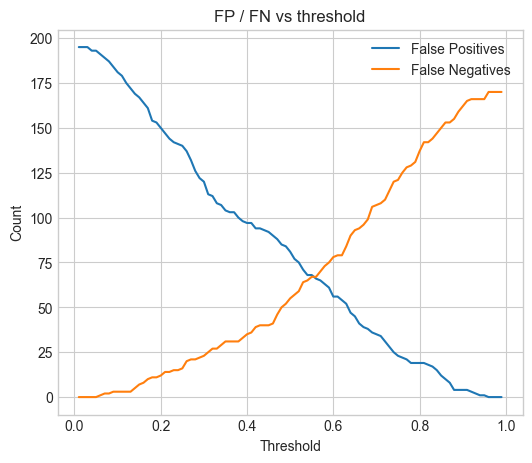

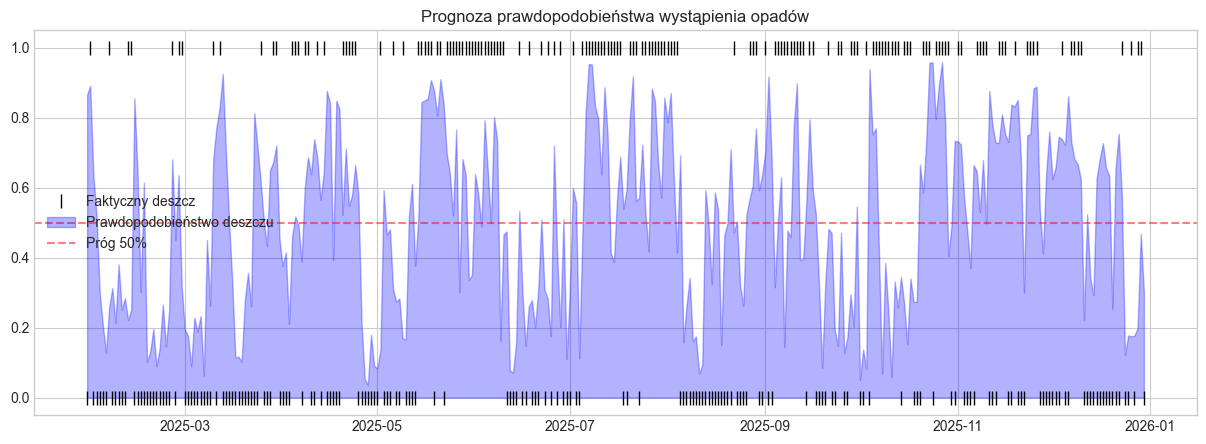

<Figure size 1000x800 with 0 Axes>

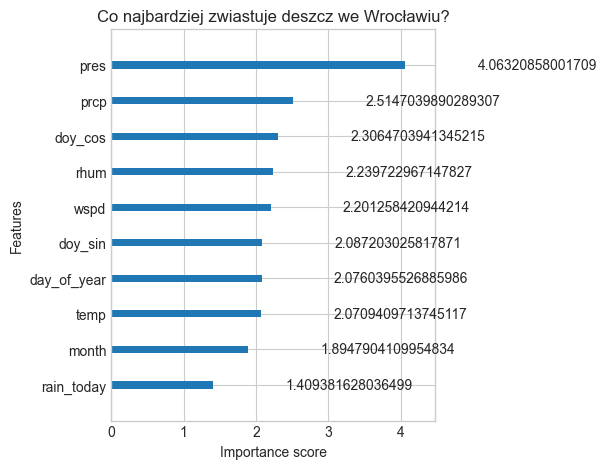

In [10]:


model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)
eval(model, X_test, y_test)

# # Wykres ważności cech
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=15, importance_type='gain')
plt.title("Co najbardziej zwiastuje deszcz we Wrocławiu?")
plt.tight_layout()
plt.show()


### XGBoost + trochę więcej cech

In [11]:

daily = prepare_data_2(df)
TEST_DAYS = 365

train = daily.iloc[:-TEST_DAYS]
test  = daily.iloc[-TEST_DAYS:]

X_train = train.drop(columns=["rain_tomorrow"])
y_train = train["rain_tomorrow"]

X_test = test.drop(columns=["rain_tomorrow"])
y_test = test["rain_tomorrow"]

In [12]:
pos_ratio = y_train.mean()
pos_ratio


np.float64(0.5184404636459431)


Raport klasyfikacji, threshold=0.5
              precision    recall  f1-score   support

         0.0      0.709     0.723     0.716       195
         1.0      0.675     0.659     0.667       170

    accuracy                          0.693       365
   macro avg      0.692     0.691     0.691       365
weighted avg      0.693     0.693     0.693       365

ROC-AUC Score: 0.7283
Confusion matrix:
[[141  54]
 [ 58 112]]


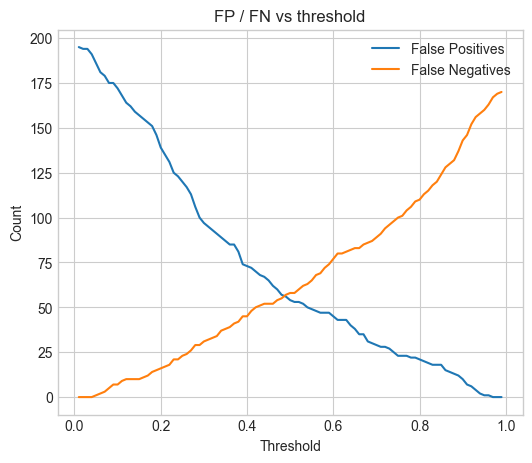

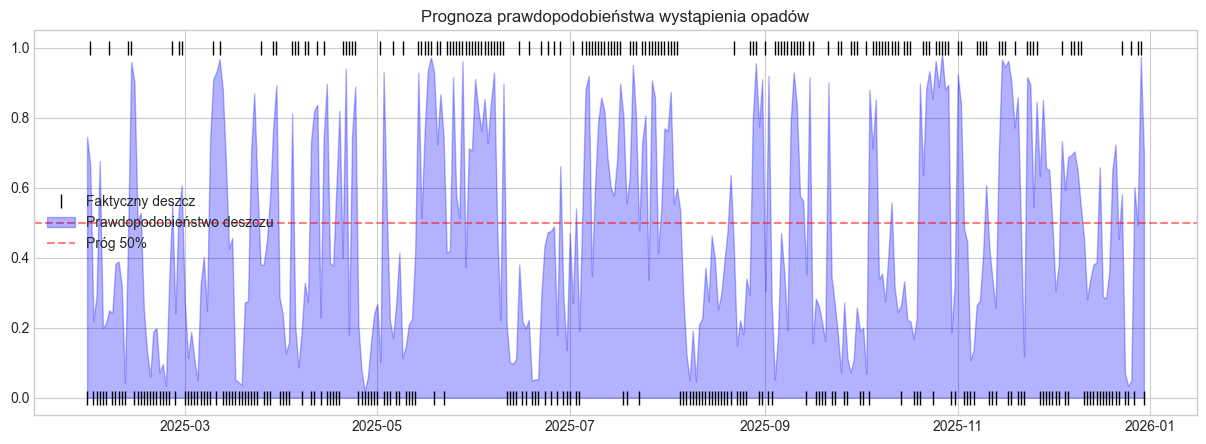

<Figure size 1000x800 with 0 Axes>

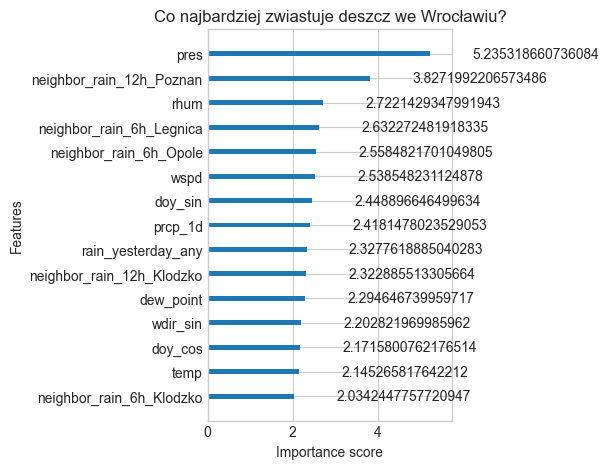

In [13]:
m_xgb = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

m_xgb.fit(X_train, y_train)
# for t in [0.3,0.35,0.4,0.45,0.5, 0.55, 0.6]:
#     eval(model, X_test, y_test, t)

eval(m_xgb, X_test, y_test, t=0.5)

# # Wykres ważności cech
plt.figure(figsize=(10, 8))
xgb.plot_importance(m_xgb, max_num_features=15, importance_type='gain')
plt.title("Co najbardziej zwiastuje deszcz we Wrocławiu?")
plt.tight_layout()
plt.show()


Raport klasyfikacji, threshold=0.5
              precision    recall  f1-score   support

         0.0      0.708     0.672     0.689       195
         1.0      0.644     0.682     0.663       170

    accuracy                          0.677       365
   macro avg      0.676     0.677     0.676       365
weighted avg      0.678     0.677     0.677       365

ROC-AUC Score: 0.7436
Confusion matrix:
[[131  64]
 [ 54 116]]


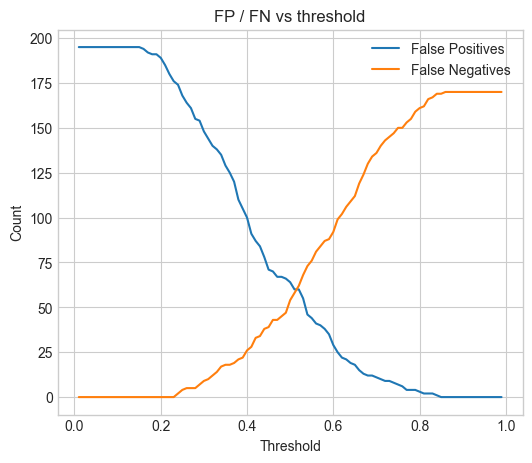

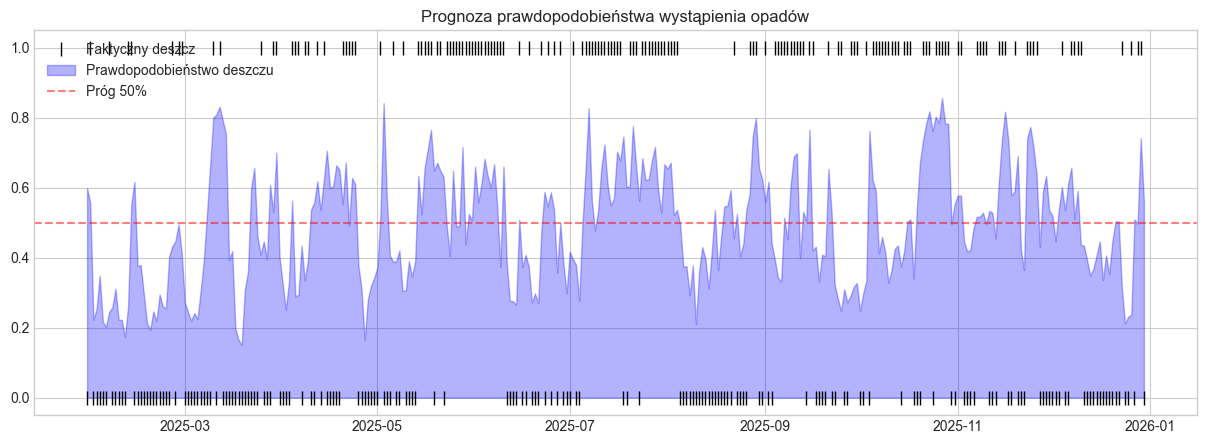

In [14]:


adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=2,
        min_samples_leaf=10,
        random_state=42
    ),
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)

adaboost.fit(X_train, y_train)

eval(adaboost, X_test, y_test, t=0.5)



Raport klasyfikacji, threshold=0.5
              precision    recall  f1-score   support

         0.0      0.713     0.738     0.725       195
         1.0      0.687     0.659     0.673       170

    accuracy                          0.701       365
   macro avg      0.700     0.699     0.699       365
weighted avg      0.701     0.701     0.701       365

ROC-AUC Score: 0.7509
Confusion matrix:
[[144  51]
 [ 58 112]]


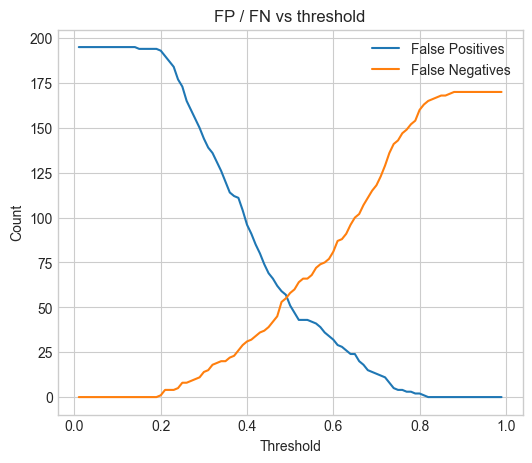

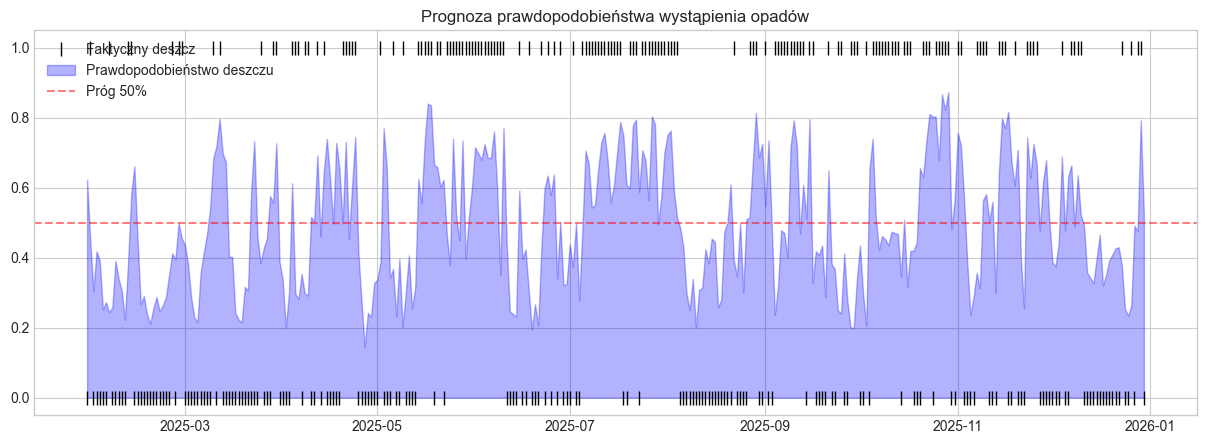

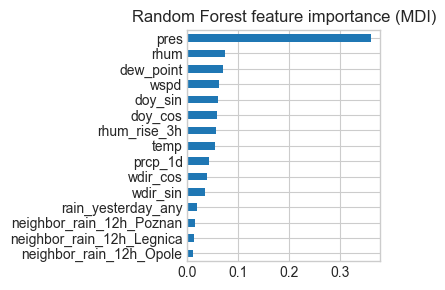

In [15]:

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=10,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

eval(rf, X_test, y_test, t=0.5)

imp = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)
imp.head(15).plot.barh(figsize=(4, 3))
plt.gca().invert_yaxis()
plt.title("Random Forest feature importance (MDI)")
plt.tight_layout()
plt.show()



In [16]:
def feature_importance(model, model_name):
    """
    Permutation importance mierzy, jak bardzo pogarsza się jakość modelu, gdy zniszczysz informację niesioną przez jedną cechę, losowo ją permutując.

    Jeśli model naprawdę z niej korzysta - wynik spada.
    Jeśli nie - wynik się prawie nie zmienia.
    """
    result = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=42, scoring="f1"
    )

    importances = pd.Series(result.importances_mean, index=X_test.columns).sort_values(
        ascending=False
    )

    importances.head(15)
    importances.head(15).plot.barh(figsize=(4, 3))
    plt.gca().invert_yaxis()
    plt.title(f"{model_name} permutation importance (F1)")
    plt.tight_layout()
    plt.show()

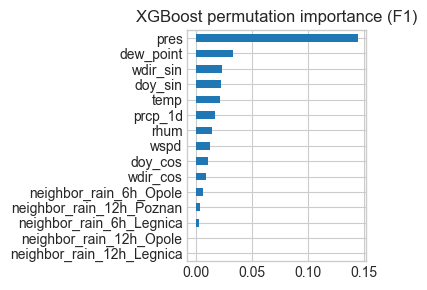

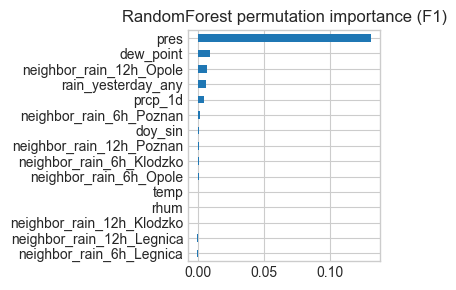

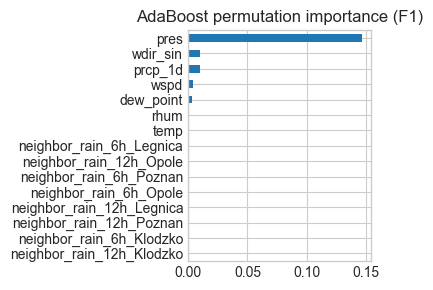

In [17]:
feature_importance(m_xgb,"XGBoost")
feature_importance(rf,"RandomForest")
feature_importance(adaboost,"AdaBoost")